In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors
import re
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /Users/michelle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/michelle/miniconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
df = pd.read_csv("ww_data_tags_labelling.csv")

In [5]:
df

,id,job_title,job_summary,job_responsibilities,required_skills,app_docs_tags,duration_tags,special_reqs_tags,keywords
0,272204,Research Assistant (Quantum Optics),The research project aims at developing: \n<br...,<ul>\n \n\t \n <li>Preparing and conducting e...,"<ul>\n \n\t \n <li style=""margin-top: 4.94mm;...","['work history', 'cover letter', 'resume', 'gr...",2 work terms preferred,['fully vaccinated'],"['optics', 'python programming', 'mathematica'..."
1,278145,Mechanical Designer,The Co-op Mechanical Designer's primary functi...,"<ul>\n \n\t \n <li>Create, design, and detail...",<ul>\n \n\t \n <li>Enrolled in Mechanical Eng...,"['work history', 'cover letter', 'resume', 'gr...",4 month,[],"['environmental conditions', 'sheet metal', 'm..."
2,278340,Water and Wastewater Asset Management,"The Region of Peel, comprised of Mississauga, ...",Your co-op term will entail a number of activi...,<ul>\n \n\t \n <li>Enrolled in a relevant pos...,"['work history', 'cover letter', 'resume', 'gr...",8 month required,[],"['technical expertise', 'technical data', 'mee..."
3,278501,Research Assistant,Timeframe - 16 weeks (January 9&nbsp;- April 2...,Work activities of the successful candidate wi...,The successful candidate will\n \n<ul>\n \n\t...,"['work history', 'resume', 'grade report']",4 month,[],"['facebook', 'instagram', 'fundraising', 'busi..."
4,278832,Full-Stack Django React Engineering at a Silic...,<strong>Who We Are</strong> \n<br>\n \n<br>\nA...,<strong>What you will do</strong>\n\n \n<ul>\n...,<strong>Who you are</strong>\n\n \n<ul>\n \n\...,"['work history', 'resume', 'grade report']",4 month,"['fully vaccinated', 'USA work eligibility']","['job', 'engineers', 'new technology', 'week',..."
...,...,...,...,...,...,...,...,...,...
2911,295823,Household Hazardous Waste Facility Operator,Location: Community Recycling Centres (CRCs) i...,"<ul>\n \n\t \n <li>Receiving, categorizing, s...",<ul>\n \n\t \n <li>Strong Customer Service sk...,"['work history', 'cover letter', 'resume', 'gr...",4 month,[],"['waste', 'shipping', 'ontario regulation', 'a..."
2912,295824,Financial Analyst,telMAX has been designing and building a cutti...,<strong><em>Cool. But what will I actually be ...,<strong><em>I'm in - but what do you need from...,"['work history', 'resume', 'grade report']",4 month,[],"['proficiency', 'forecasts', 'accounting', 'go..."
2913,295825,Research Engineering Intern,The student will be a member of the PROPEL Lab...,<ul>\n \n\t \n <li>Assist in the development ...,<ul>\n \n\t \n <li>Students must be enrolled ...,"['work history', 'cover letter', 'resume', 'gr...",8 month required,[],"['working knowledge', 'workflows', 'mechanical..."
2914,295829,"Costco Relations, Marketing Operations",<strong>About GM</strong> \n<br>\nOur vision i...,<strong>Key Responsibilities:</strong>\n\n \n<...,<strong>Qualifications:</strong>\n\n \n<ul>\n ...,"['work history', 'resume', 'grade report']",8 month required,['external application'],"['innovative thinking', 'program performance',..."


In [7]:
df_final = df[['id','job_title','keywords']]

In [8]:
df_final.iloc[0]

id                                                      272204
job_title                  Research Assistant (Quantum Optics)
keywords     ['optics', 'python programming', 'mathematica'...
Name: 0, dtype: object

In [9]:
#title cleaning
def sanitize(text):
    #normalize
    text = text.lower()
    text = re.sub("january","",text)
    text = re.sub("co-op","",text)
    text = re.sub('(\d)+', '', text)
    text = re.sub("months",'',text)
    text = re.sub("month",'',text)
    text = re.sub("winter","",text)
    text = re.sub("fall","",text)
    text = re.sub("summer","",text)
    text = re.sub("spring","",text)
    text = re.sub("term","",text)
    text = re.sub("student","",text)
    text = re.sub("intern","",text)
    text = re.sub(" - ","",text)
    text = re.sub("opportunities, ","",text)
    text = re.sub("opportunities","",text)
    text = re.sub(",,","",text)
    text = re.sub("   ","",text)
    text = re.sub("  ","",text)
    text = re.sub(", "," ",text)
    text = re.sub("()","",text)
    text = re.sub("junior ","",text)
    return text

In [10]:
df_final['sanitized'] = df_final.apply(lambda row: sanitize(row['job_title']),axis=1)

/var/folders/1k/574_07wn3z9gjzqfqkpdl06h0000gn/T/ipykernel_11828/1957703009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['sanitized'] = df_final.apply(lambda row: sanitize(row['job_title']),axis=1)


In [12]:
df_final['sanitized'] = df_final['sanitized'] + df_final['keywords']

/var/folders/1k/574_07wn3z9gjzqfqkpdl06h0000gn/T/ipykernel_11828/3900911690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['sanitized'] = df_final['sanitized'] + df_final['keywords']


In [28]:
text = df_final['sanitized']

In [29]:
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text)

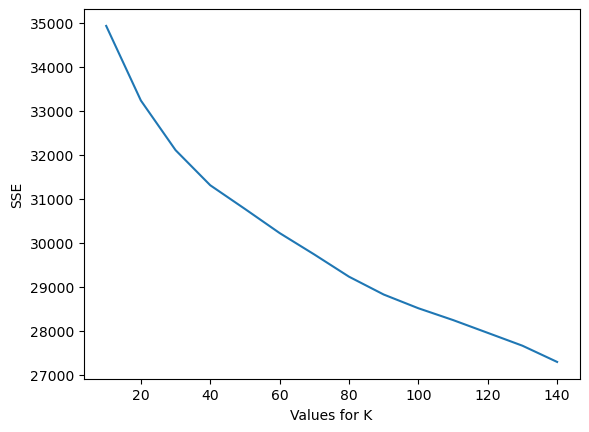

In [30]:
sse={}
for k in np.arange(10,150,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show()

In [31]:
#create clusters
kmeans = KMeans(n_clusters=50)
kmeans.fit(X_cv)
result = pd.concat([text,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_cv)

/Users/michelle/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
#Label each cluster with the word(s) that all of its food names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='sanitized' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [34]:
df_results = result_labelled[['sanitized','cluster','label_y']]

In [35]:
df_results.to_csv("df_results.csv",index=False)

In [42]:
df

,id,job_title,job_summary,job_responsibilities,required_skills,app_docs_tags,duration_tags,special_reqs_tags,keywords
0,272204,Research Assistant (Quantum Optics),The research project aims at developing: \n<br...,<ul>\n \n\t \n <li>Preparing and conducting e...,"<ul>\n \n\t \n <li style=""margin-top: 4.94mm;...","['work history', 'cover letter', 'resume', 'gr...",2 work terms preferred,['fully vaccinated'],"['optics', 'python programming', 'mathematica'..."
1,278145,Mechanical Designer,The Co-op Mechanical Designer's primary functi...,"<ul>\n \n\t \n <li>Create, design, and detail...",<ul>\n \n\t \n <li>Enrolled in Mechanical Eng...,"['work history', 'cover letter', 'resume', 'gr...",4 month,[],"['environmental conditions', 'sheet metal', 'm..."
2,278340,Water and Wastewater Asset Management,"The Region of Peel, comprised of Mississauga, ...",Your co-op term will entail a number of activi...,<ul>\n \n\t \n <li>Enrolled in a relevant pos...,"['work history', 'cover letter', 'resume', 'gr...",8 month required,[],"['technical expertise', 'technical data', 'mee..."
3,278501,Research Assistant,Timeframe - 16 weeks (January 9&nbsp;- April 2...,Work activities of the successful candidate wi...,The successful candidate will\n \n<ul>\n \n\t...,"['work history', 'resume', 'grade report']",4 month,[],"['facebook', 'instagram', 'fundraising', 'busi..."
4,278832,Full-Stack Django React Engineering at a Silic...,<strong>Who We Are</strong> \n<br>\n \n<br>\nA...,<strong>What you will do</strong>\n\n \n<ul>\n...,<strong>Who you are</strong>\n\n \n<ul>\n \n\...,"['work history', 'resume', 'grade report']",4 month,"['fully vaccinated', 'USA work eligibility']","['job', 'engineers', 'new technology', 'week',..."
...,...,...,...,...,...,...,...,...,...
2911,295823,Household Hazardous Waste Facility Operator,Location: Community Recycling Centres (CRCs) i...,"<ul>\n \n\t \n <li>Receiving, categorizing, s...",<ul>\n \n\t \n <li>Strong Customer Service sk...,"['work history', 'cover letter', 'resume', 'gr...",4 month,[],"['waste', 'shipping', 'ontario regulation', 'a..."
2912,295824,Financial Analyst,telMAX has been designing and building a cutti...,<strong><em>Cool. But what will I actually be ...,<strong><em>I'm in - but what do you need from...,"['work history', 'resume', 'grade report']",4 month,[],"['proficiency', 'forecasts', 'accounting', 'go..."
2913,295825,Research Engineering Intern,The student will be a member of the PROPEL Lab...,<ul>\n \n\t \n <li>Assist in the development ...,<ul>\n \n\t \n <li>Students must be enrolled ...,"['work history', 'cover letter', 'resume', 'gr...",8 month required,[],"['working knowledge', 'workflows', 'mechanical..."
2914,295829,"Costco Relations, Marketing Operations",<strong>About GM</strong> \n<br>\nOur vision i...,<strong>Key Responsibilities:</strong>\n\n \n<...,<strong>Qualifications:</strong>\n\n \n<ul>\n ...,"['work history', 'resume', 'grade report']",8 month required,['external application'],"['innovative thinking', 'program performance',..."


In [47]:
df_results

,sanitized,cluster,label_y
0,"research assistant (quantum optics)['optics', ...",29,
1,mechanical designer['environmental conditions'...,47,
2,water and wastewater asset management['technic...,14,technical
3,"research assistant['facebook', 'instagram', 'f...",48,assistant
4,full-stack django react engineering at a silic...,5,new
...,...,...,...
2911,household hazardous waste facility operator['w...,9,accounting
2912,"financial analyst['proficiency', 'forecasts', ...",7,financial
2913,"research engineering ['working knowledge', 'wo...",17,engineering
2914,costco relations marketing operations['innovat...,11,


In [45]:
df_new = df[['id','job_title','job_summary','keywords']]

In [48]:
df_new['industry'] = df_results['label_y'].values

/var/folders/1k/574_07wn3z9gjzqfqkpdl06h0000gn/T/ipykernel_11828/2978376137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['industry'] = df_results['label_y'].values


In [50]:
df_new.to_csv("df_results.csv",index=False)